In [30]:

import os

import numpy as np
import pandas as pd

# from BaseFunctionsDef import *
from IPython.core.display import display
import base64
import importlib
from IPython.display import Image
import plotly.graph_objects as go
import plotly.express as px


pd.set_option('max_columns', None)
pd.set_option('mode.chained_assignment', 'raise')

In [56]:
import dvwtools.read as dv
import dvwtools.stats as dvstats


In [32]:
# Loads the image of the volleyball court
path_image = os.path.join("assets", "mezzoCampo_up.png")
path_image_set = os.path.join("assets", "mezzoCampo.png")

# Just some handling of the volleyball court image
encoded_image_up = base64.b64encode(open(path_image, 'rb').read())
encoded_image_down = base64.b64encode(open(path_image_set, 'rb').read())

In [33]:
import config
df = pd.read_parquet(path=config.s3_bucket + 'complete_df.parquet.gzip', storage_options={"key": config.access_key, "secret": config.secret_key})
df_pass = dv.get_reception_df(df)
teams_list = pd.read_parquet(path=config.s3_bucket + 'teams.parquet.gzip', storage_options={"key": config.access_key, "secret": config.secret_key})
giocatori_list = pd.read_parquet(path=config.s3_bucket + 'players.parquet.gzip', storage_options={"key": config.access_key, "secret": config.secret_key})

In [34]:
df_usa = df_pass[df_pass.SquadraCodice == 'USA']

In [35]:
keep_cols = ['Competizione', 'Round', 'Date', 'TeamAvvName', 'PuntiInt', 'PuntiOsp', 'currentset',
            'iz', 'az',
             'ServeGiocatoreName', 'x_p', 'y_p',
             'GiocatoreName', 'valutazione',  'x_a', 'y_a', 'CurrentPlayerPosition',
             'SecondTouchGiocatoreName', 'SecondTouchGrade', 'SecondTouchX_start', 'SecondTouchY_start',
             'SideoutAttackGiocatoreName', 'SideoutAttackGrade',
             'SideoutAttackX_start', 'SideoutAttackY_start',
             'IsRallyWon', 'IsSetWon', 'IsMatchWon']

df_clear = df_usa[keep_cols]
df_clear.columns = keep_cols

df_clear = df_clear.rename(columns=
    {'Competizione': 'competition',
     'Round': 'round',
     'Date': 'date',
     'TeamAvvName': 'opponent_team',
     'PuntiInt': 'score_home',
     'PuntiOsp': 'score_guest',
     'currentset': 'current_game',
     'valutazione': 'reception_quality',
     'GiocatoreName': 'reception_player',
     'CurrentPlayerPosition': 'reception_player_position',
     'iz': 'rotation_home',
     'az': 'rotation_guest',
     'x_p': 'serve_x',
     'y_p': 'serve_y',
     'x_a': 'reception_x',
     'y_a': 'reception_y',
     'ServeGiocatoreName': 'serve_player',
     'SecondTouchGiocatoreName': 'set_player',
     'SecondTouchGrade': 'set_quality',
     'SecondTouchX_start': 'set_x',
     'SecondTouchY_start': 'set_y',
     'SideoutAttackGiocatoreName': 'attack_player',
     'SideoutAttackGrade': 'attack_quality',
     'SideoutAttackX_start': 'attack_x',
     'SideoutAttackY_start': 'attack_y',
     }
)

quality = ['#', '+', '!', '-', '/', '=']
setter_quality = ['#', '+', '!', '-', '/', '=', 'No Set']
atk_quality = ['#', '+', '!', '-', '/', '=', 'No Attack']
df_clear.reception_quality = df_clear.reception_quality.astype(pd.CategoricalDtype(quality, ordered=True))
df_clear.set_quality = df_clear.set_quality.astype(pd.CategoricalDtype(setter_quality, ordered=True))
df_clear.attack_quality = df_clear.attack_quality.astype(pd.CategoricalDtype(atk_quality, ordered=True))

# Analysis of USA Women's Volleyball performance in year 2021
### October 2021
#### Andrea Biasioli

<br><br><br>

# Index
- [Introduction to the dataset](#dataset)
- [Dataset structure and attributes](#structure)
- [Initial plan for data exploration and data cleaning](#plan)
> [1. Find null values and duplicates<br>](#null)
> [2. Analyze (x,y) coordinate pairs<br>](#pairs)
> [3. Quality parameters analysis](#quality)
- [New feature definition: IsSideoutPoint](#issideoutpoint)
- [Key Finding: relationship between passing quality and sideout performance](#receptionattack)
- [Key Finding: relationship between passing quality and set coordinates](#qualityset)
- [Hypothesis testing and significance tests](#hypotesis)
> [1. Lower performance when receiving in zone 1<br>](#hyp1)
> [2. Better performance with starting-six setter<br>](#hyp2)
> [3. Better performance during 2020 Tokyo Olympics](#hyp3)
- [Feature engineering for ML](#features)
- [Next steps](#next)
- [Considerations on the dataset](#considerations)

<br><br>

<a id='dataset'></a>

# Dataset
The dataset is an original dataset for sideout attacks of Team USA. The data was personally collected and validated using Data Volley (the leading software for volleyball statistics collection) and complemented using Hudl Volleymetrics.


What is a side-out? A side-out is identified by four distinct steps:
1. Serve (from the opponent team)
2. **Reception (also called *pass*)** (Team USA)
3. **Set** (Team USA)
4. **Attack** (Team USA). This attack is also identified as **side-out attack**

Please see the image below as reference.



![](./images/cumulated.jpg)


<br>

## Player positions or roles
In volleyball, each team is allowed to touch the ball only three times before giving the ball to the opponent team trying to score. For example, you could say that in each side-out the first touch is the reception, the second is the set, the third is the attack.

Six players for each team are present on the court at any given time. High-level volleyball teams are highly specialized, and the six players can be summarized in:
- **Setter** (SET): a player that is specialized in the second touch
- **Opposite** (OPP): its position in court is opposite to the setter one. Usually he/she is responsible for attacking, while being excluded from receiving.
- **Outside hitters** (OH1 and OH2): they are usually tasked with both receiving and attacking.
- **Middle blockers** (MB1 and MB2): usually tasked with attacking only, mostly very quick attacks (first tempo)
- **Libero** (L): a libero can enter the court before each rally replacing one of the above players in the back row.

For more info, please see here for more details: http://www.volleyballadvisors.com/volleyball-positions.html

<br>
## Scoring
Sets (also known as games) end at 25 points, except the 5th (tie-break) at 15. Teams must win by a margin larger or equal to two points.

**Rally Point System**: each rally (whether my team starts by serving or by receiving) will grant a point either for my team or for the opponent team.

<a id='structure'></a>

<br><br>

# Sideout dataset structure

Each record in the data set corresponds to one side-out (i.e., one serve + one pass + one set + one attack).

Let's take a look at four random row of the dataset to better explain the structure.

In [36]:
display(df_clear.sample(4, random_state=1))

,competition,round,date,opponent_team,score_home,score_guest,current_game,rotation_home,rotation_guest,serve_player,serve_x,serve_y,reception_player,reception_quality,reception_x,reception_y,reception_player_position,set_player,set_quality,set_x,set_y,attack_player,attack_quality,attack_x,attack_y,IsRallyWon,IsSetWon,IsMatchWon
19335,2020 Tokyo Olympics,Qualification Round,2021-07-25,Argentina,24,20,3,6,5,Farriol Bianca,38,5,Wong-Orantes Justine,-,59,77,L,Poulter Jordyn,#,64.0,44.0,Thompson Jordan,#,88.0,49.0,True,True,True
19078,2020 Tokyo Olympics,Qualification Round,2021-07-25,Argentina,6,3,3,6,5,Farriol Bianca,36,2,Larson Jordan,#,79,77,OH2,Poulter Jordyn,#,49.0,45.0,Larson Jordan,#,16.0,46.0,True,True,True
160879,VNL 2021,Week 5,2021-06-19,Russia,4,2,1,2,1,Startseva Evgeniya,63,1,Hill Kimberly,#,23,69,L,Poulter Jordyn,#,62.0,47.0,Robinson Kelsey,/,52.0,34.0,False,True,True
50565,2020 Tokyo Olympics,Qualification Round,2021-08-02,Italy,7,10,1,1,1,Malinov Ofelia,50,3,Bartsch-Hackley Michelle,+,51,78,OH2,Poulter Jordyn,#,57.0,43.0,Drews Andrea,/,87.0,42.0,False,False,True


<br><br>

The first 9 columns relate to information needed to properly contestualize the side-out:
- competition, round, date, opponent_team
- score_home: as we are considering Team USA, score_home will always represent the score for Team USA.
- score_guest: opponent team score
- current_game: it identifies the current game (also known as set)
- rotation_home: it identifies the setter location in the court for Team USA (see https://en.wikipedia.org/wiki/Volleyball#Rules_of_the_game)
- rotation_guest: setter location for the guest team

The next 3 columns collect **SERVE** information:
- serve_player: the player of the opponent team that is serving
- serve_x: the x coordinate of the serve
- serve_y: the y coordinate of the serve

The next 5 columns refer to the **RECEPTION** info for Team USA:
- reception_player: the player of Team USA who received the ball
- reception_quality
- reception_x: the x coordinate of the reception
- reception_y: the y coordinate of the reception
- reception_player_position: which position the receiver is playing in (L, OH1, Oh2, ...)

The next 4 columns refer to the **SET** info for Team USA:
- set_player: the player who set the ball for Team USA
- set_quality
- set_x: the x coordinate of the set
- set_y: the y coordinate of the set

The next 4 columns refer to the **ATTACK** info for Team USA:
- attack player: the player who attacked for Team USA
- attack_quality:
- attack_x: the x coordinate of the attack
- attack_y: the y coordinate of the attack

The last 3 columns contain boolean info:
- IsRallyWon: it tells whether or not this rally was won
- IsSetWon: it tells whether or not the current set was won
- IsMatchWon: it tells whether or not the match was won

<br><br><br><br>

The datatypes and structure are here represented:

In [37]:
df_clear.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1502 entries, 8070 to 174040
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   competition                1502 non-null   category      
 1   round                      1502 non-null   category      
 2   date                       1502 non-null   datetime64[ns]
 3   opponent_team              1502 non-null   category      
 4   score_home                 1502 non-null   int8          
 5   score_guest                1502 non-null   int8          
 6   current_game               1502 non-null   category      
 7   rotation_home              1502 non-null   int64         
 8   rotation_guest             1502 non-null   int64         
 9   serve_player               1502 non-null   category      
 10  serve_x                    1502 non-null   int8          
 11  serve_y                    1502 non-null   int8          
 12  r

<a id='plan'></a>

<br><br>

# Initial plan for data exploration
1. Find null values and duplicates
2. Analyze the (x,y) coordinates for serve, receive, set, attack
3. Analyze quality categories for serve, receive, attack


<a id='null'></a>

<br>

## 1. Find null values and duplicates
To find duplicates, I will check whether two or more rows present the same combination of competition, round, date, opponent_team, score_home, score_guest, current_game.
These parameters identify one and only one sideout attack.


In [38]:
print('Duplicated rows:')
dups = df_clear.duplicated(subset=['competition', 'round', 'date', 'opponent_team', 'score_home', 'score_guest', 'current_game'], keep=False)
print(dups.value_counts())
dups = df_clear[dups]

Duplicated rows:
False    1502
dtype: int64


No duplicate rows were found.


<a id='pairs'></a>

<br>

## 2. Analyze (x,y) pairs

Let's take a look at descriptive statistics for the court coordinate values.



In [39]:
df_clear[['serve_x', 'serve_y', 'reception_x', 'reception_y', 'set_x', 'set_y', 'attack_x', 'attack_y']].describe()
df_clear = df_clear.drop(columns='serve_y')

One first observation is that serve_y coordinate is not helpful: as expected, all serves should start before the court line (located at y = 10) and are concentrated in the y=0 to y=9 region. Moreover, the minimum y is -2, which should not be an allowed value. Therefore I will drop the feature serve_y.

<br>

### serve_x:

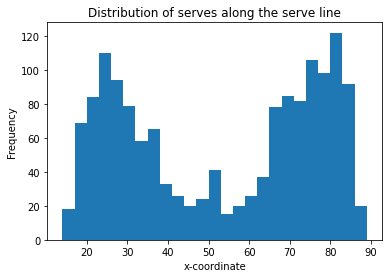

In [40]:
ax = df_clear.serve_x.plot.hist(bins=25)
ax.set(xlabel='x-coordinate',
       ylabel='Frequency',
       title='Distribution of serves along the serve line');

From the plot we can notice that 10 < serve_x < 90. This is expected, as x = 10 and x = 90 denote the coordinates of the two court corners along the serve line. Note that serve_x coordinate presents a bimodal distribution.

<br>

### reception_x
Reception uses the same coordinate set as serve (as seen in the image above). From the descriptive stats I can notice that 10 < reception_x < 90, which is expected. The variable distribution looks fairly uniform.

<br>

### reception_y
The y-coordinate for reception should span from y = 50 to y = 90, as verified from the descriptive stats. The variable distribution is strongly left-skewed. The outliers are valid points, so they will not be excluded from the analysis.


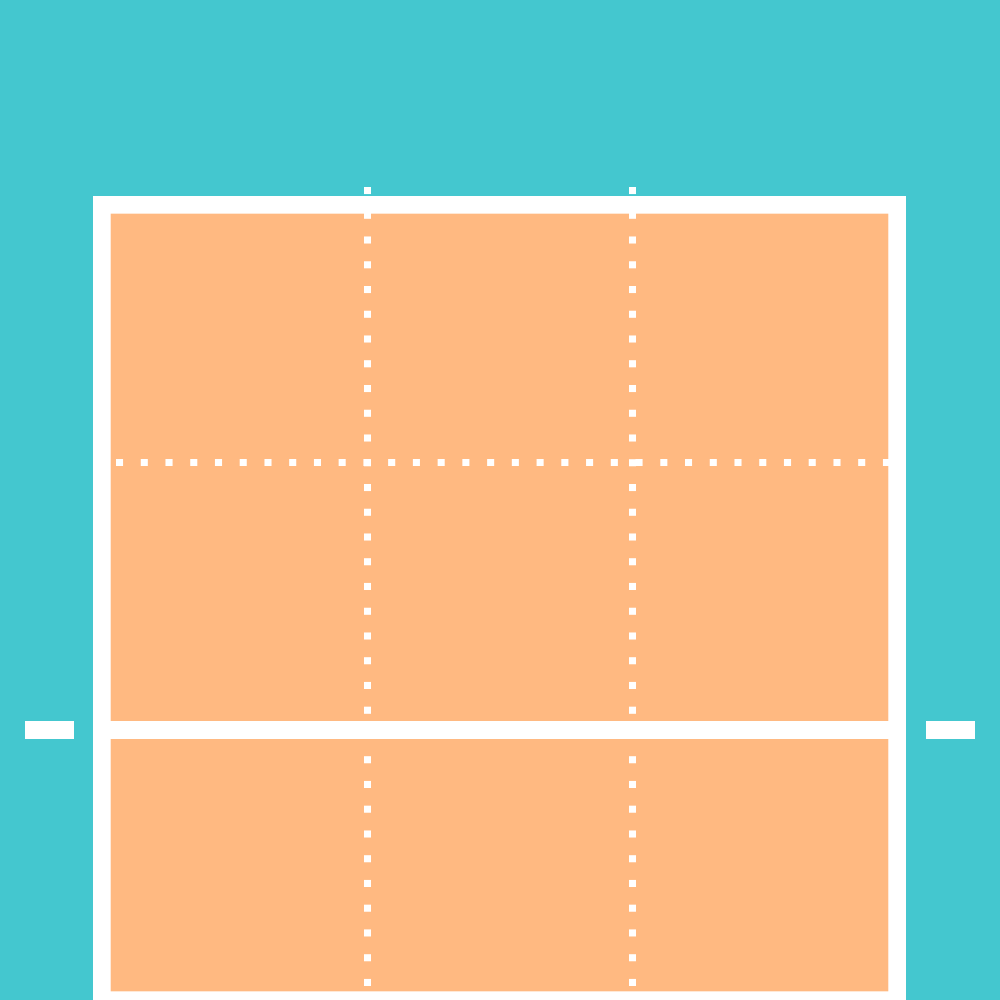

In [41]:
fig = go.FigureWidget()

trace1 = fig.add_scattergl(
    x=df_clear.reception_x,
    y=df_clear.reception_y,
    mode='markers',
    name='points',
    marker = dict(
        size=10,
        opacity=.4,
        color='white',
        line = dict(width=2, color = '#1f77b4')
        )
)

trace2 = fig.add_histogram(
    x=df_clear.reception_x,
    name='x density',
    marker=dict(color='#1f77b4', opacity=0.7),
    yaxis='y2'

)
trace3 = fig.add_histogram(
    y=df_clear.reception_y,
    name='y density',
    marker=dict(color='#1f77b4', opacity=0.7),
    xaxis='x2'
)

fig.layout = dict(
    images=[
        dict(
            source='data:image/png;base64,{}'.format(encoded_image_up.decode()),
            xref='x',
            yref='y',
            x=0,
            xanchor='left',
            y=50,
            yanchor='bottom',
            sizex=100,
            sizey=50,
            sizing='stretch',
            opacity=1,
            visible=True,
            layer='below'
    )],
    xaxis= dict(
        range=[0, 100],
        domain=[0, 0.75],
        title='',
        showticklabels=False,
        showgrid=False,
        showline=True,
        mirror=True,
        # fixedrange=True,
        # constrain='domain',
    ),
    yaxis=dict(
        range=[50, 100],
        domain=[0, 0.75],
        # title='',
        scaleanchor= 'x',
        scaleratio= 2,
        showticklabels=False,
        showline=True,
        mirror=True,
        # showgrid=False,
        # fixedrange=True,
        # constrain='domain',
    ),
    showlegend=False,
    margin=dict(t=50),
    hovermode='closest',
    bargap=0,
    xaxis2=dict(domain=[0.75, 1], showgrid=False, zeroline=False, showline=True, mirror=True,),
    yaxis2=dict(domain=[0.75, 1], showgrid=False, zeroline=False, showline=True, mirror=True,),
    width=1000,
)
fig.update_layout(title='Location of receptions')
fig.show()

<br>

### set_x
Set and attack use a different coordinate set, flipped with respect to the serve/receive one. This is confusing, but it is the current standard.

Intuitively, the origin always lies on the court close to the bottom-left corner of the "attacking" team side.
When we are looking at the sideout attack, the origin is in the bottom left corner of Team USA. On the other hand, when talking about serve, the opponent team has the first chance of "attacking" Team USA with their serve, hence the origin for serve (and reception) is on the opponent team side.

We notice some values of x = -1. These are not outliers, but they are illegal values for the coordinate. Let's peek into 5 random rows where set_x = -1.

<br>

In [42]:
display(df_clear[(df_clear.set_x == -1)])

,competition,round,date,opponent_team,score_home,score_guest,current_game,rotation_home,rotation_guest,serve_player,serve_x,reception_player,reception_quality,reception_x,reception_y,reception_player_position,set_player,set_quality,set_x,set_y,attack_player,attack_quality,attack_x,attack_y,IsRallyWon,IsSetWon,IsMatchWon
8231,VNL 2021,Week 3,2021-06-07,Korea,13,11,1,6,5,Han Songyi,35,Bartsch-Hackley Michelle,+,63,77,OH2,Hancock Micha,=,-1.0,-1.0,No Attacker,No Attack,34.0,2.0,False,True,True
18505,2020 Tokyo Olympics,Qualification Round,2021-07-25,Argentina,0,0,1,2,1,Mayer Victoria,60,Bartsch-Hackley Michelle,-,74,80,OH1,Wong-Orantes Justine,#,-1.0,-1.0,Bartsch-Hackley Michelle,-,11.0,49.0,False,True,True
72265,VNL 2021,Week 1,2021-05-27,Brazil,2,2,4,5,5,Araujo De Souza Mayany Cristina,35,Larson Jordan,!,46,72,OH1,Poulter Jordyn,+,-1.0,-1.0,Wilhite Parson Sarah,#,11.0,43.0,True,True,True
85291,VNL 2021,Week 2,2021-05-31,Serbia,2,1,2,3,6,Lazovic Katarina,30,Bartsch-Hackley Michelle,-,81,78,OH1,Washington Haleigh,=,-1.0,-1.0,No Attacker,No Attack,23.0,3.0,False,True,True
85534,VNL 2021,Week 2,2021-05-31,Serbia,20,12,2,6,3,Mirosavljevic Jovana,23,Bartsch-Hackley Michelle,-,29,80,OH1,Poulter Jordyn,+,-1.0,-1.0,Ogbogu Chiaka,-,46.0,44.0,False,True,True
121641,VNL 2021,Week 3,2021-06-08,Italy,15,15,3,4,2,Lubian Marina,40,Bartsch-Hackley Michelle,#,59,81,OH1,Poulter Jordyn,+,-1.0,-1.0,Poulter Jordyn,=,46.0,46.0,False,False,True
170324,VNL 2021,Final Four,2021-06-25,Brazil,22,22,2,4,6,Rodrigues Fernanda,36,Bartsch-Hackley Michelle,-,49,74,OH1,Poulter Jordyn,+,-1.0,-1.0,Poulter Jordyn,+,48.0,47.0,True,True,True


<br>

Of the initial 1502 rows, 7 rows present illegal set_x values. As they are only 0.46% of the rows, I will fill them with the mean value for set_x.

In [43]:
mean_x = df_clear.set_x.mean()
df_clear.loc[df_clear.set_x == -1, 'set_x'] = mean_x

<br>
### set_y

I will replace the illegal values for set_y with the mean value of the column as well.

In [44]:
mean_y = df_clear.set_y.mean()
df_clear.loc[df_clear.set_y == -1, 'set_y'] = mean_y


<br>

### Presence of null values

The coordinate columns set_x and set_y contain null values as well. Let's take a look at them.
<br>

In [45]:
display(df_clear.loc[df_clear.set_y.isna()])

,competition,round,date,opponent_team,score_home,score_guest,current_game,rotation_home,rotation_guest,serve_player,serve_x,reception_player,reception_quality,reception_x,reception_y,reception_player_position,set_player,set_quality,set_x,set_y,attack_player,attack_quality,attack_x,attack_y,IsRallyWon,IsSetWon,IsMatchWon
8124,VNL 2021,Week 3,2021-06-07,Korea,6,5,1,5,4,Jeong Jiyun,64,Wong-Orantes Justine,=,12,71,L,No Setter,No Set,NaN,NaN,No Attacker,No Attack,NaN,NaN,False,True,True
8447,VNL 2021,Week 3,2021-06-07,Korea,11,4,2,4,1,Yeum Hye Seon,85,Bartsch-Hackley Michelle,=,68,79,OH2,No Setter,No Set,NaN,NaN,No Attacker,No Attack,NaN,NaN,False,True,True
8449,VNL 2021,Week 3,2021-06-07,Korea,11,5,2,4,1,Yeum Hye Seon,81,Bartsch-Hackley Michelle,=,89,77,OH2,No Setter,No Set,NaN,NaN,No Attacker,No Attack,NaN,NaN,False,True,True
8591,VNL 2021,Week 3,2021-06-07,Korea,1,1,3,1,6,Pyo Seungju,85,Hill Kimberly,/,33,77,OH1,No Setter,No Set,NaN,NaN,No Attacker,No Attack,NaN,NaN,True,True,True
8733,VNL 2021,Week 3,2021-06-07,Korea,9,7,3,2,1,Kim Dain,86,Bartsch-Hackley Michelle,=,40,80,OH2,No Setter,No Set,NaN,NaN,No Attacker,No Attack,NaN,NaN,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173150,VNL 2021,Final Four,2021-06-24,Turkey,4,1,1,1,5,Caliskan Kubra,28,Bartsch-Hackley Michelle,/,69,76,OH2,No Setter,No Set,NaN,NaN,No Attacker,No Attack,NaN,NaN,False,True,True
173276,VNL 2021,Final Four,2021-06-24,Turkey,12,11,1,2,6,Baladin Hande,81,Larson Jordan,=,86,79,OH1,No Setter,No Set,NaN,NaN,No Attacker,No Attack,NaN,NaN,False,True,True
173520,VNL 2021,Final Four,2021-06-24,Turkey,3,7,2,3,2,Dündar Eda Erdem,56,Larson Jordan,/,79,80,OH1,No Setter,No Set,NaN,NaN,No Attacker,No Attack,NaN,NaN,False,True,True
173681,VNL 2021,Final Four,2021-06-24,Turkey,16,20,2,3,2,Dündar Eda Erdem,57,Bartsch-Hackley Michelle,=,37,85,OH2,No Setter,No Set,NaN,NaN,No Attacker,No Attack,NaN,NaN,False,True,True


<br>

The null values are located in correspondance of '=' and '/' reception quality. This is not a coincidence, as those two quality symbols are associated to the worst reception outcomes.

More specifically, '=' refers to a service ace, with the opponent team scoring a direct point with their service; as such, there is no set and no attack associated with that reception. Please look also at set and attack columns to verify that no attack and no set are present.

The symbol '/' is associated with a "half-point": it is a bad quality reception that does not allow Team USA to build an attack. Instead, it has to gift the ball (so-called "free ball") to the opponent team that will have the chance of attacking first in that rally. Once again this outcome is associated with missing set and missing attack.

I will leave the null values in set_x, set_y, attack_x, attack_y unaltered for this reason.

<br><br>

<a id='quality'></a>


## 3. Quality analysis

<br>

### Reception quality
Let's take a look at the categories for reception_quality.

The categories are:

'#' < '+' < '!' < '-' < '/' < '='

ordered from best quality (left) to worse quality (right).

In general:
- **'#'** and **'+'**: positive outcomes
- **'!'** and **'-'**: neutral/negative outcomes
- **'='** and **'/'**: very negative outcome, the opponent team scores (ace) or gets a "half point"

<br>


In [46]:
import plotly.express as px
fig = px.histogram(df_clear.sort_values(by='reception_quality'), x='reception_quality')
fig.update_xaxes(type='category')
fig.update_layout(xaxis_title='Reception quality index', yaxis_title='Count (-)', title='Frequency plot: reception_quality', width = 600)
fig.show()



<br>

### Set quality
The categories are:

'#' < '+' < '!' < '-' < '/' < '=' < 'No Set'

ordered from best quality (left) to worse quality (right), with the exception of No Set (sideout where a set is not present). This attribute is of little importance, but I will keep it uniquely to properly identify 'No Set' situations.

<br>

In [47]:
import plotly.express as px
fig = px.histogram(df_clear.sort_values(by='set_quality'), x='set_quality')
fig.update_xaxes(type='category')
fig.update_layout(xaxis_title='Set quality index', yaxis_title='Count (-)', title='Frequency plot: set_quality', width = 600)
fig.show()


<br>

### Attack quality
The categories are:

'#' < '+' < '!' < '-' < '/' < '=' < 'No Attack'

ordered from best quality (left) to worse quality (right), with the exception of No Attack (sideout where an attack is not present, either because of a very bad reception outcome, or a very negative set outcome).

In general:
- **'#'** : very positive outcome (point scored)
- **'+'**: positive outcome (another chance to attack)
- **'!'**: neutral (attack is blocked and covered by the defense)
- **'-'**: neutral/negative (the opponent defended the attack and can counter attack)
- **'='** and **'/'**: very negative outcome, the opponent team scores (error in attack or opponent block point respectively)

<br>


In [48]:
import plotly.express as px
fig = px.histogram(df_clear.sort_values(by='attack_quality'), x='attack_quality')
fig.update_xaxes(type='category')
fig.update_layout(xaxis_title='Attack quality index', yaxis_title='Count (-)', title='Frequency plot: attack_quality', width = 600)
fig.show()




<br><br><br>

# Visualization of the flow of a sideout rally

Please note that the nodes on the right are not just related to the first sideout attack, but they summarize the final outcome of the rally instead (the outcome of the first sideout attack is uniquely determined by the attack_quality, the second node level in the Sankey plot).

This visualization is very powerful especially if compared to other teams' ones.



In [49]:

# Sankey

distinct_pass_qualities = pd.Series(range(len(df_clear.reception_quality.unique())), index=df_clear.reception_quality.unique().sort_values())

offset = len(distinct_pass_qualities)

distinct_attack_qualities = pd.Series(range(offset, offset + len(df_clear.attack_quality.unique())), index=df_clear.attack_quality.unique().sort_values())

offset = len(distinct_pass_qualities) + len(distinct_attack_qualities)

distinct_rally_outcome = pd.Series([offset, offset+1], index=['No', 'Yes'])

nodes_dict = {}
for d in [distinct_pass_qualities, distinct_attack_qualities, distinct_rally_outcome]:
  nodes_dict.update(dict((v,k) for k,v in d.items()))

distinct_rally_outcome = pd.Series([offset, offset+1], index=[False, True])

nodes_df = pd.DataFrame(data={'node_val': nodes_dict.values()})
nodes_df['node_label'] = ["Pass #", "Pass +", "Pass !", "Pass -", "Pass /", "Pass =", "Atk #", "Atk +", "Atk !", "Atk -", "Atk /",
             "Atk =", "No Attack", "Lost Rally", "Won Rally"]
nodes_df['category'] = ["Pass", "Pass", "Pass", "Pass", "Pass", "Pass", "Atk", "Atk", "Atk", "Atk", "Atk",
             "Atk", "Atk", "Rally", "Rally"]

nodes_df['node_color'] = [px.colors.diverging.RdYlGn[9], px.colors.diverging.RdYlGn[9], px.colors.diverging.RdYlGn[6],
              px.colors.diverging.RdYlGn[6], px.colors.diverging.RdYlGn[0], px.colors.diverging.RdYlGn[0],
              px.colors.diverging.RdYlGn[9], px.colors.diverging.RdYlGn[9], px.colors.diverging.RdYlGn[6],
              px.colors.diverging.RdYlGn[6], px.colors.diverging.RdYlGn[0], px.colors.diverging.RdYlGn[0],
              px.colors.diverging.RdYlGn[0], px.colors.diverging.RdYlGn[0], px.colors.diverging.RdYlGn[9],
              ]

df_copy = df_clear.copy()
df_copy['reception_quality_index'] = df_copy['reception_quality'].map(distinct_pass_qualities)
df_copy['attack_quality_index'] = df_copy['attack_quality'].map(distinct_attack_qualities)
df_copy['rally_outcome_index'] = df_copy['IsRallyWon'].map(distinct_rally_outcome)

link1_df = pd.pivot_table(df_copy,
                            index=['reception_quality_index', 'attack_quality_index'],
                            aggfunc='size').reset_index()
link1_df = link1_df.rename(columns={0: 'Count', 'reception_quality_index': 'source', 'attack_quality_index': 'dest'})
link1_df['occurrence_perc'] = link1_df.Count / link1_df.groupby(by='source').Count.transform('sum')

link2_df = pd.pivot_table(df_copy,
                            index=['attack_quality_index', 'rally_outcome_index'],
                            aggfunc='size').reset_index()
link2_df = link2_df.rename(columns={0: 'Count', 'attack_quality_index': 'source', 'rally_outcome_index': 'dest'})
link2_df['occurrence_perc'] = link2_df.Count / link2_df.groupby(by='source').Count.transform('sum')

links_df = link1_df.append(link2_df, ignore_index=True)

nodes_df['source_sum'] = links_df.groupby('source').Count.sum().append(links_df.groupby('dest').Count.sum().loc[13:14])
nodes_df['category_sum'] = nodes_df.groupby(by='category').source_sum.transform('sum')
nodes_df['category_occurrence_perc'] = nodes_df['source_sum'] / nodes_df.category_sum


In [50]:
x1 = .05
x2 = 0.5
x3 = 0.95

data = [go.Sankey(
    arrangement='snap',
    # valuesuffix=" times",
    node=dict(
        pad=15,
        thickness=20,
        customdata=nodes_df.category_occurrence_perc * 100,
        x=[x1, x1, x1, x1, x1, x1, x2, x2, x2, x2, x2, x2, x2, x3, x3],
        y=[.1, .2, .3, .4, .5, .6, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.2],
        hovertemplate='%{customdata:.1f}% of sideouts (%{value:d} times)<extra></extra>',
        line=dict(color="black", width=0.5),
        label=nodes_df.node_label,
        color=nodes_df.node_color,
    ),
    link=dict(
        source=links_df.source,
        target=links_df.dest,
        value=links_df.Count,
        customdata=links_df.occurrence_perc * 100,
        hovertemplate='Pass <b>%{source.label}</b> to ' +
                      'attack <b>%{target.label}</b><br><b>%{customdata:.1f}%</b> (' +
                      '%{value} times)<extra></extra>',
    ))]

layout = go.Layout(
    title='Flow of a rally based on pass quality',
    # annotations=annotations,
    # hovermode='closest',
    # showlegend=False,
    autosize=True,

    # yaxis={'title': 'Positive pass(%)', 'showticklabels': True, 'showgrid': True,
    #        'automargin': True, 'range': [0, 100], 'dtick': 10},
    # xaxis=dict(
    #     showticklabels=True,
    #     title='Number of sets [-]',
    #     dtick=5,
    #     automargin=True
    # ),
)

figure = {
    'data': data,
    'layout': layout
}

fig = go.Figure(figure)
fig.show()

<a id='issideoutpoint'></a>



<br><br>
# New feature: IsSideoutPoint

I will add a new column **IsSideoutPoint**, with values of *True* when the attack quality is "#" (a sideout attack point is scored), *False* otherwise.
This feature will allow me to compare the outcome of a sideout with **binomial distribution** (True/False).
<br>

In [51]:
df_clear = df_clear.assign(IsSideoutPoint=[True if val == '#' else False for val in df_clear.attack_quality])

In [52]:
display(df_clear.sample(5, random_state=1))

,competition,round,date,opponent_team,score_home,score_guest,current_game,rotation_home,rotation_guest,serve_player,serve_x,reception_player,reception_quality,reception_x,reception_y,reception_player_position,set_player,set_quality,set_x,set_y,attack_player,attack_quality,attack_x,attack_y,IsRallyWon,IsSetWon,IsMatchWon,IsSideoutPoint
19335,2020 Tokyo Olympics,Qualification Round,2021-07-25,Argentina,24,20,3,6,5,Farriol Bianca,38,Wong-Orantes Justine,-,59,77,L,Poulter Jordyn,#,64.0,44.0,Thompson Jordan,#,88.0,49.0,True,True,True,True
19078,2020 Tokyo Olympics,Qualification Round,2021-07-25,Argentina,6,3,3,6,5,Farriol Bianca,36,Larson Jordan,#,79,77,OH2,Poulter Jordyn,#,49.0,45.0,Larson Jordan,#,16.0,46.0,True,True,True,True
160879,VNL 2021,Week 5,2021-06-19,Russia,4,2,1,2,1,Startseva Evgeniya,63,Hill Kimberly,#,23,69,L,Poulter Jordyn,#,62.0,47.0,Robinson Kelsey,/,52.0,34.0,False,True,True,False
50565,2020 Tokyo Olympics,Qualification Round,2021-08-02,Italy,7,10,1,1,1,Malinov Ofelia,50,Bartsch-Hackley Michelle,+,51,78,OH2,Poulter Jordyn,#,57.0,43.0,Drews Andrea,/,87.0,42.0,False,False,True,False
164813,VNL 2021,Week 5,2021-06-20,China,13,18,3,4,2,Yuan Xinyue,28,Hill Kimberly,+,29,79,L,Hancock Micha,#,64.0,42.0,Washington Haleigh,#,83.0,42.0,True,False,False,True


<a id='receptionattack'></a>

<br><br><br>

# Investigate reception quality and sideout point frequency
We saw that the highest possible quality reception symbol is '#'. How is our sideout point frequency in every reception quality class?

In [53]:
grouped_reception = df_clear.groupby('reception_quality').agg({'IsSideoutPoint': 'mean'})
display(grouped_reception)

fig = px.histogram(grouped_reception.sort_values(by='reception_quality'),
                   x=grouped_reception.index,
                   y='IsSideoutPoint')
fig.update_xaxes(type='category')
fig.update_layout(xaxis_title='Reception quality index', yaxis_title='Frequency', title='Sideout points frequency based on reception_quality', width = 600)
fig.show()

,IsSideoutPoint
reception_quality,
#,0.575145
+,0.487676
!,0.452381
-,0.292035
/,0.000000
=,0.000000


In [54]:
# Hypotesis testing plot
def get_binomial_plot(var1, name1, var2, name2, n_events):
    k = np.arange(0, n_events, 1)
    mean1 = var1
    x1_max_predict = int(np.ceil(binom.ppf(0.95, n_events, mean1)))
    x1_min_predict = int(np.floor(binom.ppf(0.05, n_events, mean1)))
    y1 = binom.pmf(k, n_events, mean1)

    mean2 = var2
    x2_max_predict = int(np.ceil(binom.ppf(0.95, n_events, mean2)))
    x2_min_predict = int(np.floor(binom.ppf(0.05, n_events, mean2)))
    y2 = binom.pmf(k, n_events, mean2)

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=k, y=y1,  mode='lines', name=name1))
    fig.add_trace(go.Scatter(x=k, y=y2,  mode='lines', name=name2))
    fig.update_layout(
        xaxis_title='Number of attacks',
        yaxis_title='PDF (-)')
    return fig


<br>

As expected, no direct sideout points are scored with '/' and '=' reception. In the other cases, higher quality reception coincides with higher sideout frequency.

The sideout score is very similar for '+' and '!' reception qualities: this is peculiar to Team USA, that is able to play quicker ball than most other teams also with a '!' reception, thereby increasing their efficiency in that particular situation.

<br><br>

<a id='qualityset'></a>

<br><br>

# Investigate relation between passing quality and set coordinates
Previous knowledge of the game informs us that the setter location (set_x and set_y coordinates) are closely related to the quality of the pass; in fact, a good quality pass will allow the setter to touch the ball always in the same position (in-system play), while a bad quality reception will force the setter to run around to chase the ball.

You don't believe me? Let's take a look.

<br>


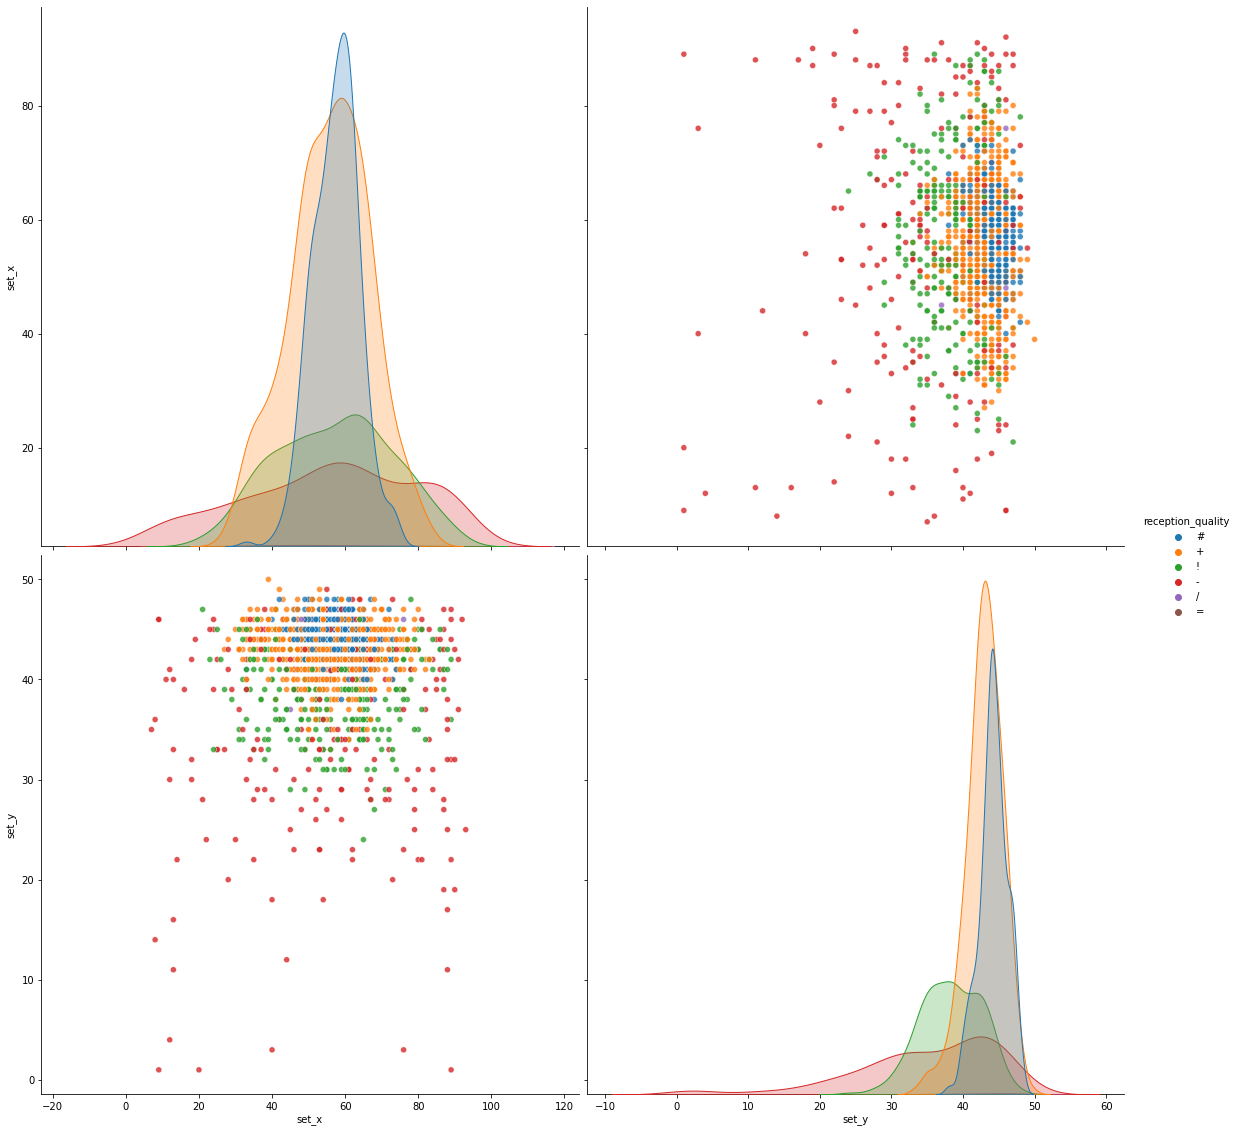

In [57]:
import seaborn as sns
sns.pairplot(df_clear[['reception_quality', 'set_x', 'set_y']], hue='reception_quality', plot_kws={'alpha':0.8}, height=8)


<br>

In the plot above we can observe set_x and set_y, colored by reception_quality. Unfortunately the scatterplots are crowded, so reception_quality clusters are hidden (we could decrease the number of datapoints to clarify the plot).

<br>

However, we can get good insights from the main diagonal.
In terms of set_x (upper-left corner):
- best quality receptions (like '#', followed by '+') are centered around the set_x = 60 mark (**perfect-pass x-location**). This leaves exactly 62.5% of the court on the left of the setter, and 37.5% on the right side of the setter. This is perfectly reasonable, if you are familiar with the game. If you are not, it builds on the fact that most people are right handed, and as such the system has evolved that way to optimize the different attack options.
- as the quality decreases, the receptions are more spread out along the court set_x coordinate
- there are also negative receptions ('-') in the perfect-pass x-location. This tells us that the set_x coordinate is not enough to distinguish a pefect pass

<br>

In terms of set_y (lower-right corner):
- best quality receptions (like '#', followed by '+') have a sharp peak centered around the set_y = 45 mark (**perfect-pass y-location**). The reason behind it is that a reception close to the net (located at set_y=50) allows for some quicker attack combinations, as the ball needs to cover less distance from set to attack.
- reception quality consistently decrease as set_y approaches 0 (the other end of the court with respect to the net)
- the coordinate set_y is strongly left skewed

<br><br>

Let's take a different look at it, with the possibility of interacting with the plot by choosing the reception quality and visualizing the set_x and set_y coordinates directly overlaying a court graphic.



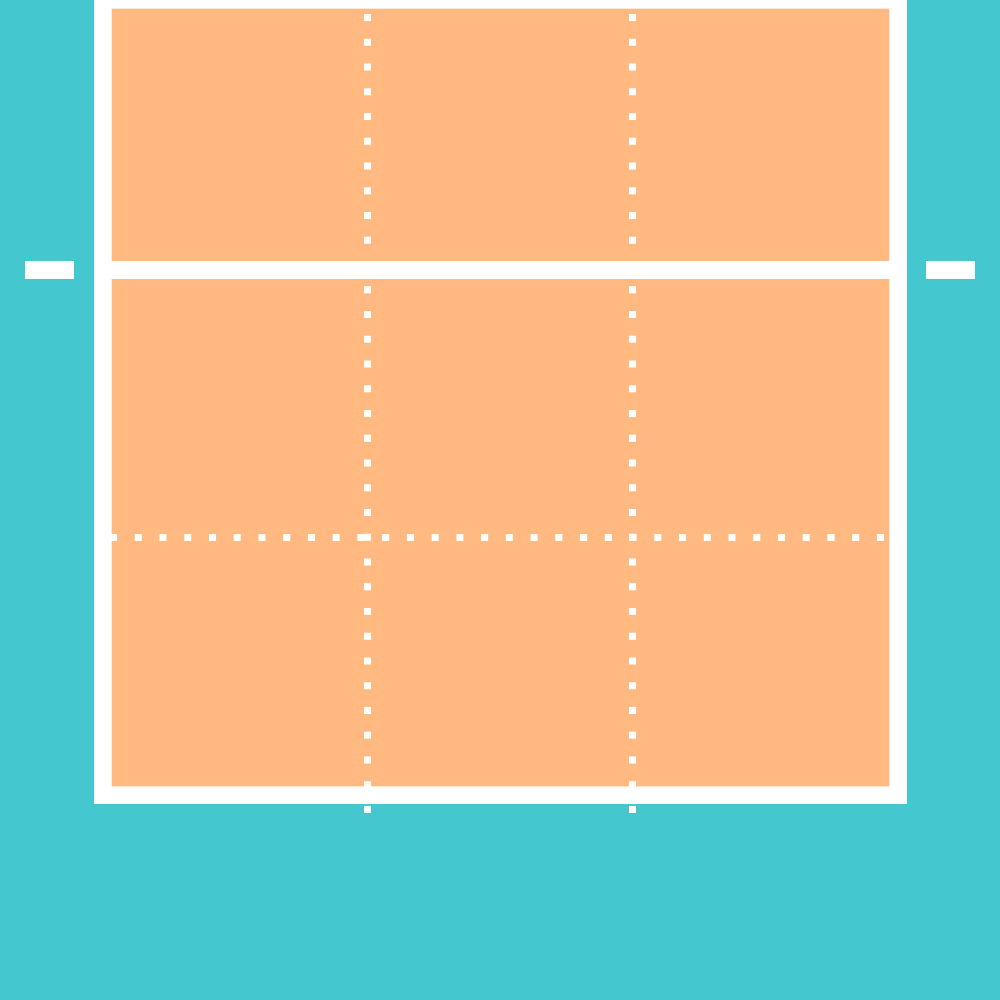

In [58]:
# Get ordered pass qualities
pass_quality = df_clear.reception_quality.cat.categories.to_numpy()

def get_set_position_map(df, reception_qualities):
    fig_map = go.Figure()
    first = True

    for quality in reception_qualities:
        quality_df = df.loc[df.reception_quality == quality]

        visible = False
        if first:
            visible = True
            first = False

        fig_map.add_trace( \
            go.Scatter(
                x=quality_df.set_x,
                y=quality_df.set_y,
                mode='markers',
                name='points',
                marker = dict(
                    size=10,
                    opacity=.4
                    ),
                visible=visible,
            )
        )
    y_label_height = 1

    fig_map.update_layout(
        dict(
            images=[
                dict(
                    source='data:image/png;base64,{}'.format(encoded_image_down.decode()),
                    xref='x',
                    yref='y',
                    x=0,
                    xanchor='left',
                    y=0,
                    yanchor='bottom',
                    sizex=100,
                    sizey=50,
                    sizing='stretch',
                    opacity=1,
                    visible=True,
                    layer='below'
            )],
            xaxis= dict(
                range=[0, 100],
                title='set_x',
                showticklabels=True,
                showgrid=False,
                # fixedrange=True,
                # constrain='domain',
            ),
            yaxis=dict(
                range=[0, 50],
                title='set_y',
                scaleanchor= 'x',
                scaleratio= 2,
                showticklabels=True,
                showgrid=False,
                # fixedrange=True,
                # constrain='domain',
            ),
            showlegend=False,
            margin=dict(t=50),
            hovermode='closest',

            updatemenus=[
            dict(
                active=0,
                buttons=list([
                    dict(
                        label=str(reception_qualities[i]),
                        method="restyle",
                        args=[
                            {"visible": [True if j==i else False for j in range(len(reception_qualities))]},
                               # {"title": f'{title_starts_with} in year {show_years[0]} worldwide'}
                               ]) for i in range(len(reception_qualities))
                ]),
                x=0.3,
                xanchor='left',
                y=y_label_height,
                yanchor='bottom',
                pad={"t": 10, "b": 10}
            )],
            annotations=[
            dict(
                text="Select reception quality:",
                x=0.3, xref="paper",
                y=1.0, yref="paper",
                xshift=-5,
                yshift=15,
                xanchor='right',
                yanchor='bottom',
                align="left", showarrow=False)],
            title={'text': 'Set coordinate grouped by reception quality', 'y': 1
                , 'yanchor': 'top', 'yref': 'container'},
            width=1000

        )
    )
    return fig_map

fig = get_set_position_map(df_clear, pass_quality)
fig.show()



<a id='hypotesis'></a>

# Hypothesis testing

I will investigate different hypotesis based on the binomial distribution of **IsSideoutPoint**. The hypotesis are here summarized:
1. Team USA has lower sideout performance when receiving in zone 1 (more details follow)
2. Team USA performs better with their starting six setter Poulter J. with respect to the second setter Hackock M.
3. Team USA has performed better during the 2020 Tokyo Olympics than in the 2021 Volleyball Nations League


<a id='hyp1'></a>

<br><br>

## Hypothesis 1: lower performance when receiving in zone 1

- $H_0$: Team USA has the same sideout performance when receving in zone 1
- $H_1$: Team USA has higher sideout performance when receiving in zone 1

Let's start by visually explaining what zone 1 refers to.




![](./images/receive_z1.jpg)

<br><br>

In terms of court coordinates, zone 1 is identified by *reception_x* $<27$.

The dataset will be split in two parts, one where *reception_x* $<27$ (to test my alternative hypotesis) and one with the remaining data (to provide the baseline for the test).
In A/B testing, the first dataset refers to the *treatment*, while the second to the *control*.

Let's build a **contingency table** for the test.

In [59]:
# Hypotesis testing
# Get all the receptions in zone 1 (27)
condition = df_clear.reception_x < 27
h0 = 'Other zone'
h1 = 'Zone 1'

temp_df = df_clear.assign(IsSelected=np.where(condition, h1, h0))
temp_df = temp_df.assign(Quantity=1)
contingency_df = pd.pivot_table(temp_df, index ='IsSelected', columns='IsSideoutPoint', values='Quantity', aggfunc='sum', margins_name='Total', margins=True)
contingency_df.index.name = None
contingency_df = contingency_df.reindex(columns=[True, False, 'Total'])
contingency_df.rename(columns={True: 'Yes', False: 'No'}, inplace=True)
contingency_df = contingency_df.reindex([h0, h1, "Total"])
display(contingency_df)
del temp_df

IsSideoutPoint,Yes,No,Total
Other zone,555,710,1265
Zone 1,101,136,237
Total,656,846,1502


In [60]:
from scipy.stats import binom

h0_success_rate = contingency_df['Yes'].loc[h0]/contingency_df['Total'].loc[h0]
h1_success_rate = contingency_df['Yes'].loc[h1]/contingency_df['Total'].loc[h1]

prob = 1 - binom.cdf(
    k = contingency_df['Yes'].loc[h1],
    n = contingency_df['Total'].loc[h1],
    p = h0_success_rate)


print(f'H0: success rate = {h0_success_rate:.4f}')
print(f'H1: success rate = {h1_success_rate:.4f}')
print(f'\nBased on a success probability of p={h0_success_rate:3f} (the baseline H0 success rate), for zone 1 the probability of getting {contingency_df["Yes"].loc[h1]} or more successes'
      f' on {contingency_df["Total"].loc[h1]} trials is {prob:3f}')



H0: success rate = 0.4387
H1: success rate = 0.4262

Based on a success probability of p=0.438735 (the baseline H0 success rate), for zone 1 the probability of getting 101 or more successes on 237 trials is 0.626335


<br>

Assuming the baseline success probability given by $H_0$ of p=0.42 (if it was a fair coin toss, this would be p=0.5), I compared the success stats for $H_1$, using $k$ as the number of successes, $n$ as the total occurrences of Zone 1.

Summarizing, I evaluated the probability of having more than 99 successes on 237 trials based on the baseline p=0.42.
The result, according to a binomial cumulative distribution function (https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.binom.html) is 0.507.

This means that 50% of the times Teams USA receives in zone 1 would do better than the baseline, and 50% of the time it would do worse, i.e., there is absolutely no difference in receiving in zone 1 or in the other zones.
This leads us to accept $H_0$.

Let's take a look on how the binomial distributions for *zone 1* and *other zones* would compare over 250 attack (using binomial probability mass function in a line plot).

In [61]:
n_attacks = 250
fig = get_binomial_plot(h1_success_rate, 'Zone 1', h0_success_rate, 'Other Zones', n_attacks)
fig.update_layout(title='Sideout performance on 250 attacks grouped by reception zone')
fig.show()

<br>

As we can see, there is absolutely no difference between the two.

Team USA is not negatively affected by receiving in zone 1.


<br><br><br>

<a id='hyp2'></a>

# Hypothesis 2: better performance with starting-six setter
- $H_0$: Team USA sideout performance with their first setter (Poulter J.) is the same as with the second setter (Hancock M.)
- $H_1$: Team USA has better sideout performance with their second setter (Hancock M.)

Let's build a **contingency table** for the test.


In [62]:
post_drop_df = df_clear[(df_clear.set_player == 'Poulter Jordyn') | (df_clear.set_player == 'Hancock Micha')]
condition = post_drop_df.set_player == 'Poulter Jordyn'
h0 = 'Poulter'
h1 = 'Hancock'

temp_df = post_drop_df.assign(IsSelected=np.where(condition, h0, h1))
temp_df = temp_df.assign(Quantity=1)
contingency_df = pd.pivot_table(temp_df, index ='IsSelected', columns='IsSideoutPoint', values='Quantity', aggfunc='sum', margins_name='Total', margins=True)
contingency_df.index.name = None
contingency_df = contingency_df.reindex(columns=[True, False, 'Total'])
contingency_df.rename(columns={True: 'Yes', False: 'No'}, inplace=True)
contingency_df = contingency_df.reindex([h0, h1, "Total"])
display(contingency_df)
del temp_df

IsSideoutPoint,Yes,No,Total
Poulter,398,433,831
Hancock,198,220,418
Total,596,653,1249


In [63]:
h0_success_rate = contingency_df['Yes'].loc[h0]/contingency_df['Total'].loc[h0]
h1_success_rate = contingency_df['Yes'].loc[h1]/contingency_df['Total'].loc[h1]

prob = 1 - binom.cdf(
    k = contingency_df['Yes'].loc[h1],
    n = contingency_df['Total'].loc[h1],
    p = h0_success_rate)


print(f'H0: success rate = {h0_success_rate:.4f}')
print(f'H1: success rate = {h1_success_rate:.4f}')
print(f'\nBased on a success probability of p={h0_success_rate:3f} (the baseline H0 success rate), for Hancock the probability of getting {contingency_df["Yes"].loc[h1]} or more successes'
      f' on {contingency_df["Total"].loc[h1]} trials is {prob:3f}')


H0: success rate = 0.4789
H1: success rate = 0.4737

Based on a success probability of p=0.478941 (the baseline H0 success rate), for Hancock the probability of getting 198 or more successes on 418 trials is 0.565719


<br>

Things are getting more interesting. Looking at the success rates, there is a 3% difference between the two values.

Can we reject $H_0$ ?

Let's take a look at the binomial cumulative distribution function: the probability of having more than 198 successes on 418 trials based on the baseline p=0.4489
is only 14%. The null hypothesis cannot be rejected at the 5% level of significance (because 14% is greater than our threshold of 5%).

A closer look at the binomial mass distribution function based on 250 attacks:

In [64]:
n_attacks = 250
fig = get_binomial_plot(h1_success_rate, h1, h0_success_rate, h0, n_attacks)
fig.update_layout(title='Sideout performance on 250 attacks grouped by setter')
fig.show()


<br>

We can notice a distinct shift between the two distributions. Having more data points in this case would be helpful to further clarify the situation, but under the current conditions we have to reject the alternative hypotesis.


<br><br>

### Binomial test

We could use the *binomtest* function to run a similar test on the results above and see if it gives a different answer.
More details on the function here: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.binomtest.html#scipy.stats.binomtest

In [65]:
from scipy.stats import binomtest
result = binomtest(k=contingency_df['Yes'].loc[h1], n=contingency_df['Total'].loc[h1], p=h0_success_rate, alternative='greater')

print(f'Results (using a "greater-than" alternative hypotesis style):\n\np-value: {result.pvalue:.3f}\nEstimated proportion (of success): {result.proportion_estimate}\nEstimated proportion (of success) 95% confidence interval: {result.proportion_ci(confidence_level=0.95)}\n')

Results (using a "greater-than" alternative hypotesis style):

p-value: 0.604
Estimated proportion (of success): 0.47368421052631576
Estimated proportion (of success) 95% confidence interval: ConfidenceInterval(low=0.4325516713635526, high=1.0)



<br>

The binomial test gives a similar result, as expected. The p-value is 16.6%, so the null hypothesis cannot be rejected at the 5% level of significance because the p-value is greater than 5%.

The 95% confidence interval for our $H_1$ is 0.43 to 1. In other words, if the $H_0$ success rate was below 0.43 then we could reject $H_0$. It is not, so we reject $H_1$.


<br><br>

### Chi-square test

Another alternative is given by the chi-square test, using *chi2_contingency* (https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chi2_contingency.html).


In [66]:
from scipy import stats
sideouts = np.array(contingency_df.iloc[:-1,:-1])
chi2, p_value, df, _ = stats.chi2_contingency(sideouts)
print(f'P-value for single-sided test, using the Pearson chi-squared statistic: {p_value / 2:.5f}')

chi2, p_value, df, _ = stats.chi2_contingency(sideouts, lambda_ = "log-likelihood")
print(f'\n\nP-value for single-sided test, using the G-test: {p_value / 2:.5f}\n')


P-value for single-sided test, using the Pearson chi-squared statistic: 0.45403


P-value for single-sided test, using the G-test: 0.45403



<br>
Once again we reject the null hypotesis.

<br><br>

### Fisher's exact test

Using the Fisher's exact test, with one-sided alternative hypotesis (https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.fisher_exact.html).
The result is once again very similar.

In [67]:
from scipy.stats import fisher_exact
sideouts[[0, 1]] = sideouts[[1,0]]
oddsratio, pvalue = fisher_exact(sideouts, alternative='greater')
print(f'Fisher exact, p-value: {pvalue:.4f}\n')


Fisher exact, p-value: 0.5930



<a id='hyp3'></a>

<br><br><br>
# Hypothesis 3: better performance during Tokyo 2020
- $H_0$: Team USA had the same sideout performance during 2020 Tokyo Olympics and 2021 Volleyball Nations League
- $H_1$: Team USA had better sideout performance during 2021 Volleyball Nations League

Let's build a **contingency table** for the test.


In [68]:
condition = df_clear.competition == '2020 Tokyo Olympics'
h0 = '2020 Olympics'
h1 = '2021 VNL'

temp_df = df_clear.assign(IsSelected=np.where(condition, h0, h1))
temp_df = temp_df.assign(Quantity=1)
contingency_df = pd.pivot_table(temp_df, index ='IsSelected', columns='IsSideoutPoint', values='Quantity', aggfunc='sum', margins_name='Total', margins=True)
contingency_df.index.name = None
contingency_df = contingency_df.reindex(columns=[True, False, 'Total'])
contingency_df.rename(columns={True: 'Yes', False: 'No'}, inplace=True)
contingency_df = contingency_df.reindex([h0, h1, "Total"])
display(contingency_df)
del temp_df

IsSideoutPoint,Yes,No,Total
2020 Olympics,204,307,511
2021 VNL,452,539,991
Total,656,846,1502


In [69]:
h0_success_rate = contingency_df['Yes'].loc[h0]/contingency_df['Total'].loc[h0]
h1_success_rate = contingency_df['Yes'].loc[h1]/contingency_df['Total'].loc[h1]

prob = 1 - binom.cdf(
    k = contingency_df['Yes'].loc[h1],
    n = contingency_df['Total'].loc[h1],
    p = h0_success_rate)


print(f'H0: success rate = {h0_success_rate:.4f}')
print(f'H1: success rate = {h1_success_rate:.4f}')
print(f'\nBased on a success probability of p={h0_success_rate:3f} (the baseline H0 success rate), in VNL the probability of getting {contingency_df["Yes"].loc[h1]} or more successes'
      f' on {contingency_df["Total"].loc[h1]} trials is {prob:e}')


H0: success rate = 0.3992
H1: success rate = 0.4561

Based on a success probability of p=0.399217 (the baseline H0 success rate), in VNL the probability of getting 452 or more successes on 991 trials is 1.231980e-04


<br>

Interestingly, it seems that we can reject the null hypotesis: in fact, Team USA had better sideout performance during the 2021 Volleyball Nations League.

In [70]:
n_attacks = 250
fig = get_binomial_plot(h1_success_rate, h1, h0_success_rate, h0, n_attacks)
fig.update_layout(title='Sideout performance on 250 attacks grouped by competition')
fig.show()

<br><br>

### Binomial test


In [71]:
from scipy.stats import binomtest
result = binomtest(k=contingency_df['Yes'].loc[h1], n=contingency_df['Total'].loc[h1], p=h0_success_rate, alternative='greater')

print(f'Results (using a "greater-than" alternative hypotesis style):\n\np-value: {result.pvalue:e}\nEstimated proportion (of success): {result.proportion_estimate}\nEstimated proportion (of success) 95% confidence interval: {result.proportion_ci(confidence_level=0.95)}\n')

Results (using a "greater-than" alternative hypotesis style):

p-value: 1.579400e-04
Estimated proportion (of success): 0.45610494450050454
Estimated proportion (of success) 95% confidence interval: ConfidenceInterval(low=0.4296981795929522, high=1.0)



The binomial test gives a similar result, as expected. The p-value is <5%, so the null hypothesis is rejected at the 5% level of significance.

The 95% confidence interval for our $H_1$ is 0.43 to 1. In other words, if the $H_0$ success rate was below 0.43 (and it is!) then we can reject $H_0$.

<br><br>

### Chi-square test

In [72]:
sideouts = np.array(contingency_df.iloc[:-1,:-1])
chi2, p_value, df, _ = stats.chi2_contingency(sideouts)
print(f'P-value for single-sided test, using the Pearson chi-squared statistic: {p_value / 2:.5f}')

chi2, p_value, df, _ = stats.chi2_contingency(sideouts, lambda_ = "log-likelihood")
print(f'\n\nP-value for single-sided test, using the G-test: {p_value / 2:.5f}\n')


P-value for single-sided test, using the Pearson chi-squared statistic: 0.02013


P-value for single-sided test, using the G-test: 0.01994



<br>
Once again we reject the null hypotesis.

<br><br>

### Fisher's exact test

Using the Fisher's exact test, with one-sided alternative hypotesis (https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.fisher_exact.html).
The result is once again very similar.

In [73]:
from scipy.stats import fisher_exact
sideouts = np.array(contingency_df.iloc[:-1,:-1])
sideouts[[0, 1]] = sideouts[[1,0]]
oddsratio, pvalue = fisher_exact(sideouts, alternative='greater')
print(f'Fisher exact, p-value: {pvalue:e}\n')




Fisher exact, p-value: 1.998440e-02



<a id='features'></a>

<br><br><br>

# Features engineering
The past sections did not need any particular preliminary work on the dataset attributes, but I will need to prepare the data for machine learning models.

<br>

First, let's take a look at the current datatypes.
<br>

In [74]:
df_clear.serve_x = df_clear.serve_x.astype(float)
df_clear.reception_x = df_clear.reception_x.astype(float)
df_clear.reception_y = df_clear.reception_y.astype(float)
display(df_clear.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1502 entries, 8070 to 174040
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   competition                1502 non-null   category      
 1   round                      1502 non-null   category      
 2   date                       1502 non-null   datetime64[ns]
 3   opponent_team              1502 non-null   category      
 4   score_home                 1502 non-null   int8          
 5   score_guest                1502 non-null   int8          
 6   current_game               1502 non-null   category      
 7   rotation_home              1502 non-null   int64         
 8   rotation_guest             1502 non-null   int64         
 9   serve_player               1502 non-null   category      
 10  serve_x                    1502 non-null   float64       
 11  reception_player           1502 non-null   category      
 12  r

None

<br><br>

Looking at the numeric attributes, investigating skew and kurtosis for my variables:

In [75]:
def get_float_shape_stats(df):
    # Create a list of float colums to check for skewing
    mask = df.dtypes == float
    float_cols = df.columns[mask]

    skew_limit = 0.75 # define a limit above which we will log transform

    skew_vals = df[float_cols].skew().reset_index()
    skew_vals.columns = ['column_name', 'Skew']
    kurt_vals = df[float_cols].kurt().reset_index()
    kurt_vals.columns = ['column_name','Kurtosis']

    summary_shape_df = skew_vals.merge(kurt_vals, how='inner', on='column_name')
    display(summary_shape_df)

get_float_shape_stats(df_clear)


,column_name,Skew,Kurtosis
0,serve_x,-0.124800,-1.599222
1,reception_x,0.114143,-1.133553
2,reception_y,-1.417888,4.623369
3,set_x,-0.319472,0.933431
4,set_y,-2.638479,10.814880
5,attack_x,0.190798,-1.709524
6,attack_y,-3.424473,18.566957


<br><br>

## reception_y
The distribution for the variable is strongly left-skewed. Applying a $log$ transformation would result in an even more skewed variable.

I will use a [*PowerTransformer*](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PowerTransformer.html#sklearn.preprocessing.PowerTransformer) and a [*QuantileTransformer*](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.QuantileTransformer.html#sklearn.preprocessing.QuantileTransformer) to reduce the left-skewdness and bring the distribution to gaussian.

In [76]:
from sklearn import preprocessing


field = "reception_y"
quantile_transformer = preprocessing.QuantileTransformer(output_distribution='normal', random_state=0)
pt = preprocessing.PowerTransformer(method='box-cox', standardize=True)
X_transformed = pt.fit_transform(np.array(df_clear[field]).reshape(-1,1))
X_trans = quantile_transformer.fit_transform(np.array(df_clear[field]).reshape(-1,1))
df_clear[f'{field}_transf_PT'] = X_transformed[:,0]
df_clear[f'{field}_transf_QT'] = X_trans[:,0]


Text(0.5, 0.98, 'reception_y variable transformation')

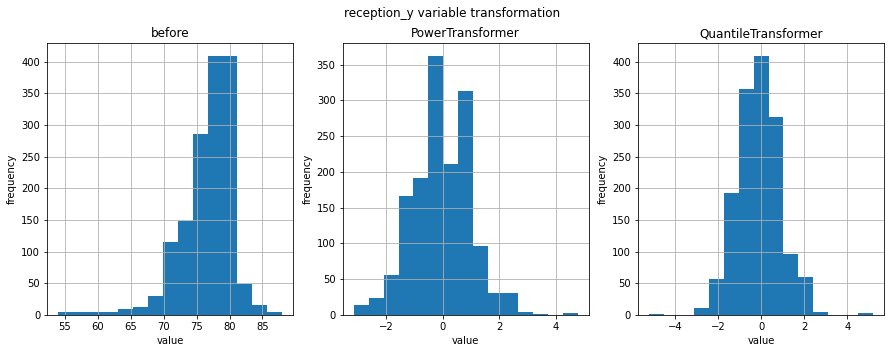

In [77]:
from matplotlib import pyplot as plt

# Create two "subplots" and a "figure" using matplotlib
fig, (ax_before, ax_after1, ax_after2) = plt.subplots(1, 3, figsize=(15, 5))

nbins = 15
# Create a histogram on the "ax_before" subplot
df_clear[field].hist(ax=ax_before, bins=nbins)

# Apply a log transformation (numpy syntax) to this column
df_clear[f'{field}_transf_PT'].hist(ax=ax_after1, bins=nbins)
df_clear[f'{field}_transf_QT'].hist(ax=ax_after2, bins=nbins)

# Formatting of titles etc. for each subplot
ax_before.set(title='before', ylabel='frequency', xlabel='value')
ax_after1.set(title='PowerTransformer', ylabel='frequency', xlabel='value')
ax_after2.set(title='QuantileTransformer', ylabel='frequency', xlabel='value')
fig.suptitle(f'{field} variable transformation')

Taking a look at the improvements in terms of skewdness and kurtosis, both transformers seem to be suitable. I will postpone the choice between the two transformed variables for now.

From the descriptive stats, notice how the transformed variables have also been scaled to zero mean and unitary standard deviation (as desirable in most ML models).

In [78]:
get_float_shape_stats(df_clear[[field, f'{field}_transf_PT', f'{field}_transf_QT' ]])

display(df_clear[[field, f'{field}_transf_PT', f'{field}_transf_QT' ]].describe().T)



,column_name,Skew,Kurtosis
0,reception_y,-1.417888,4.623369
1,reception_y_transf_PT,0.085272,1.206756
2,reception_y_transf_QT,0.055488,1.621081


,count,mean,std,min,25%,50%,75%,max
reception_y,1502.0,7.660320e+01,3.900281,54.000000,75.000000,77.000000,79.000000,88.000000
reception_y_transf_PT,1502.0,1.419193e-16,1.000333,-3.133788,-0.572633,-0.028396,0.599974,4.770398
reception_y_transf_QT,1502.0,-1.012143e-04,1.022882,-5.199338,-0.641002,-0.060256,0.641002,5.199338


<br><br>

## set_y
The distribution for the variable set_y is similarly strongly left-skewed.
I will use a *PowerTransformer* and a *QuantileTransformer*.


In [79]:
field = "set_y"
quantile_transformer = preprocessing.QuantileTransformer(output_distribution='normal', random_state=0)
pt = preprocessing.PowerTransformer(method='box-cox', standardize=True)
X_transformed = pt.fit_transform(np.array(df_clear[field]).reshape(-1,1))
X_trans = quantile_transformer.fit_transform(np.array(df_clear[field]).reshape(-1,1))
df_clear[f'{field}_transf_PT'] = X_transformed[:,0]
df_clear[f'{field}_transf_QT'] = X_trans[:,0]


Text(0.5, 0.98, 'set_y variable transformation')

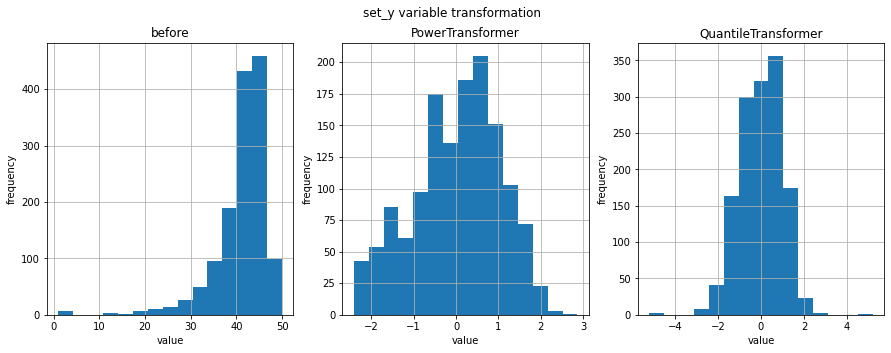

In [80]:
from matplotlib import pyplot as plt

# Create two "subplots" and a "figure" using matplotlib
fig, (ax_before, ax_after1, ax_after2) = plt.subplots(1, 3, figsize=(15, 5))

nbins = 15
# Create a histogram on the "ax_before" subplot
df_clear[field].hist(ax=ax_before, bins=nbins)

# Apply a log transformation (numpy syntax) to this column
df_clear[f'{field}_transf_PT'].hist(ax=ax_after1, bins=nbins)
df_clear[f'{field}_transf_QT'].hist(ax=ax_after2, bins=nbins)

# Formatting of titles etc. for each subplot
ax_before.set(title='before', ylabel='frequency', xlabel='value')
ax_after1.set(title='PowerTransformer', ylabel='frequency', xlabel='value')
ax_after2.set(title='QuantileTransformer', ylabel='frequency', xlabel='value')
fig.suptitle(f'{field} variable transformation')

<br>

In this case, the Quantile Transformer seems to more efficiently bring the distribution to normal.
<br>

In [81]:
get_float_shape_stats(df_clear[[field, f'{field}_transf_PT', f'{field}_transf_QT' ]])
display(df_clear[[field, f'{field}_transf_PT', f'{field}_transf_QT' ]].describe().T)

,column_name,Skew,Kurtosis
0,set_y,-2.638479,10.814880
1,set_y_transf_PT,-0.412760,-0.296241
2,set_y_transf_QT,-0.177344,1.392417


,count,mean,std,min,25%,50%,75%,max
set_y,1395.0,4.112502e+01,5.855582,1.000000,40.000000,43.000000,45.000000,50.000000
set_y_transf_PT,1395.0,2.037399e-17,1.000359,-2.418950,-0.534486,0.213885,0.829844,2.869268
set_y_transf_QT,1395.0,-6.216724e-03,1.016886,-5.199338,-0.622621,0.084155,0.846279,5.199338


<br><br>

## attack_y
The distribution for the variable is strongly left-skewed and bimodal. Values below $y<30$ are outliers and should be filtered out from the transformation.
I will set those values to *null*.

Is outlier for attack_y:


False    1490
True       12
Name: attack_y, dtype: int64





Count of null values after outlier edit: 119






Text(0.5, 0.98, 'attack_y variable transformation')

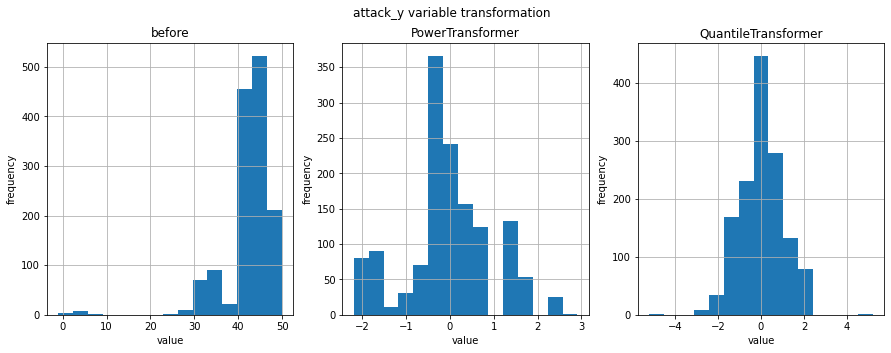

In [82]:
field = "attack_y"

# Create two "subplots" and a "figure" using matplotlib
fig, (ax_before, ax_after1, ax_after2) = plt.subplots(1, 3, figsize=(15, 5))

nbins = 15
# Create a histogram on the "ax_before" subplot
df_clear[field].hist(ax=ax_before, bins=nbins)

filtering = df_clear.attack_y < 20
print('Is outlier for attack_y:')
display(filtering.value_counts())

df_clear.loc[filtering, 'attack_y'] = np.NaN
df_clear['attack_y'] = df_clear.attack_y.replace({-1: np.NaN})

print(f'\n\n\n\nCount of null values after outlier edit: {len(df_clear[df_clear.attack_y.isna()])}\n\n\n\n')


quantile_transformer = preprocessing.QuantileTransformer(output_distribution='normal', random_state=0)
pt = preprocessing.PowerTransformer(method='box-cox', standardize=True)
X_transformed = pt.fit_transform(np.array(df_clear[field]).reshape(-1,1))
X_trans = quantile_transformer.fit_transform(np.array(df_clear[field]).reshape(-1,1))
df_clear[f'{field}_transf_PT'] = X_transformed[:,0]
df_clear[f'{field}_transf_QT'] = X_trans[:,0]


# Apply a log transformation (numpy syntax) to this column
df_clear[f'{field}_transf_PT'].hist(ax=ax_after1, bins=nbins)
df_clear[f'{field}_transf_QT'].hist(ax=ax_after2, bins=nbins)

# Formatting of titles etc. for each subplot
ax_before.set(title='before', ylabel='frequency', xlabel='value')
ax_after1.set(title='PowerTransformer', ylabel='frequency', xlabel='value')
ax_after2.set(title='QuantileTransformer', ylabel='frequency', xlabel='value')
fig.suptitle(f'{field} variable transformation')

<br>

Also in this case, the Quantile Transformer seems to more efficiently bring the distribution to normal.
<br>

In [83]:
get_float_shape_stats(df_clear[[field, f'{field}_transf_PT', f'{field}_transf_QT' ]])
display(df_clear[[field, f'{field}_transf_PT', f'{field}_transf_QT' ]].describe().T)


,column_name,Skew,Kurtosis
0,attack_y,-1.467730,1.737840
1,attack_y_transf_PT,-0.153914,-0.132750
2,attack_y_transf_QT,-0.040437,0.685225


,count,mean,std,min,25%,50%,75%,max
attack_y,1383.0,4.273391e+01,4.392310,24.000000,42.000000,44.000000,45.000000,50.000000
attack_y_transf_PT,1383.0,-3.390876e-16,1.000362,-2.199439,-0.473203,0.112551,0.460897,2.912668
attack_y_transf_QT,1383.0,-2.745340e-03,0.999010,-5.199338,-0.634851,0.143512,0.527858,5.199338



<br><br>

## reception_quality
It will be useful to convert the categorical features as well, for example reception_quality.

I will use the OrdinalEncoder transformer, as the different qualities categories are indeed ordered.


In [84]:
# Manage the quality of the pass
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder(categories=[quality[::-1]])
reception_quality_encoded = enc.fit_transform(X=np.array(df_clear.reception_quality).reshape(-1,1))
df_clear['reception_quality_encoded'] = reception_quality_encoded

print(f'\nEncoder: {enc}\n')
print(f'\nValues:\n{df_clear["reception_quality_encoded"].value_counts()}\n')


Encoder: OrdinalEncoder(categories=[['=', '/', '-', '!', '+', '#']])


Values:
4.0    568
5.0    346
3.0    252
2.0    226
0.0     64
1.0     46
Name: reception_quality_encoded, dtype: int64



<br><br><br><br>

...to be continued

<a id='next'></a>

<br><br>
# Next steps

- Appropriately transform and scale the remaining features
- Evaluate the different possible transformations on each variable, and find a metric to evaluate them
- Issue of attack_quality transform: not every (ordinal) value has the same weight. Devise a proper scaling solution
- Use ML clustering to find a way to predict reception_quality based on setter coordinates (and possibly other parameters)




<br><br>

<a id='considerations'></a>

<br>

# Additional considerations
The dataset is sufficiently comprehensive, with enough datapoints to carry out meaningful analysis.

Additional features, such as the time delta between each ball touch (for example, between reception and set) could be helpful.

Comparing to other teams performance is also desirable.


In [ ]:
# Manage the quality of the attack
# enc = OrdinalEncoder(categories=[atk_quality[::-1]])
# attack_quality_encoded = enc.fit_transform(X=np.array(df_clear.attack_quality).reshape(-1,1))
# df_clear['attack_quality_encoded'] = attack_quality_encoded
# df_clear['attack_quality_encoded'].describe()
# df_clear['attack_quality_encoded'].hist()
